---

# <center>★ AI / ML Project - Sentiment Analysis ★

---

<img src="mv.jpg" style="width: 400px;"/>

---

### Description:

The dataset is comprised of tab-separated files with phrases from the Rotten Tomatoes dataset. The train/test split has been preserved for the purposes of benchmarking, but the sentences have been shuffled from their original order. Each Sentence has been parsed into many phrases by the Stanford parser. Each phrase has a PhraseId. Each sentence has a SentenceId. Phrases that are repeated (such as short/common words) are only included once in the data.

train.tsv contains the phrases and their associated sentiment labels. We have additionally provided a SentenceId so that you can track which phrases belong to a single sentence.
test.tsv contains just phrases. You must assign a sentiment label to each phrase.
The sentiment labels are:

0 - negative
1 - somewhat negative
2 - neutral
3 - somewhat positive
4 - positive

The dataset can be downloaded here: https://archive.ics.uci.edu/ml/datasets/spambase

### Objective:
- Understand the Dataset & cleanup (if required).
- Build classification models to predict the ratings of the movie.
- Compare the evaluation metrics of vaious classification algorithms.

---

## <center>1. Data Exploration

In [28]:
#Importing the necessary librarires

import math
import nltk
import scipy
import string
import numpy as np
import pandas as pd
import seaborn as sns

from tqdm import tqdm
from scipy.stats import randint
from wordcloud import WordCloud
from multiprocessing import Pool
from nltk.corpus import stopwords
from scipy.stats import loguniform

from sklearn.decomposition import PCA
from nltk.stem.porter import PorterStemmer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, \
roc_auc_score, roc_curve, precision_score, recall_score

from IPython.display import display

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]

import warnings 
warnings.filterwarnings('ignore')

In [3]:
#Importing the dataset

df = pd.read_csv('train.csv', header=0)
target = 'label'
df.reset_index(drop=True, inplace=True)
original_df = df.copy(deep=True)
display(df.head())

print('\n\033[1mInference:\033[0m The Datset consists of {} features & {} samples.'.format(df.shape[1], df.shape[0]))

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1



Inference: The Datset consists of 2 features & 40000 samples.


In [4]:
#Checking the dtypes of all the columns

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40000 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


In [5]:
#Checking the stats of all the columns

display(df.describe())

,label
count,40000.000000
mean,0.499525
std,0.500006
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


**Inference:** The stats seem to be fine, let us gain more undestanding by visualising the dataset.

---

## <center> 2. Data Preprocessing

In [6]:
#Check for empty elements

print(df.isnull().sum())
print('\n\033[1mInference:\033[0m The dataset doesn\'t have any null elements')

text     0
label    0
dtype: int64

Inference: The dataset doesn't have any null elements


In [7]:
#Removal of any Duplicate rows (if any)

counter = 0
r,c = original_df.shape

df1 = df.drop_duplicates()
df1.reset_index(drop=True, inplace=True)

if df1.shape==(r,c):
    print('\n\033[1mInference:\033[0m The dataset doesn\'t have any duplicates')
else:
    print(f'\n\033[1mInference:\033[0m Number of duplicates dropped/fixed ---> {r-df1.shape[0]}')


Inference: Number of duplicates dropped/fixed ---> 277


In [8]:
#Filtering the text

import nltk
import string
from tqdm import tqdm
from multiprocessing import Pool
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

df = df1.copy()

def preprocessor(text):
    text = text.lower()
    text = ''.join([i for i in text if i in string.ascii_lowercase+' '])
    text = ' '.join([PorterStemmer().stem(word) for word in text.split()])
    text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])
    return text

#with Pool(4) as p:
#    df['text'] = list(tqdm(p.imap(preprocessor, range(df.shape[0]))))
for i in tqdm(range(df.shape[0])):
    df.loc[i,'text'] = preprocessor(df['text'][i])

#from tqdm.contrib.concurrent import process_map 

#df['text'] = process_map(tqdm(preprocessor, df['text'], max_workers=8))

#for i in tqdm()

df.head()

100%|██████████████████████████████████████████████████████████████████████████| 39723/39723 [1:08:20<00:00,  9.69it/s]


,text,label
0,grew b watch love thunderbird mate school watc...,0
1,put thi movi dvd player sat coke chip expect w...,0
2,whi peopl know particular time past wa like fe...,0
3,even though great interest biblic movi wa bore...,0
4,im die hard dad armi fan noth ever chang got t...,1


**Inference:** The text is now clean up with the removal of all punctuations, stopwords & stemming. 

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.stem.porter import PorterStemmer
porter=PorterStemmer()
def tokenizer(text):
        return text.split()
def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

tfidf=TfidfVectorizer(strip_accents=None,lowercase=False,preprocessor=None,tokenizer=tokenizer_porter,use_idf=True,norm='l2',smooth_idf=True)
y=df.label.values
x=tfidf.fit_transform(df.text)

---

## <center> 3. Exploratory Data Analysis (EDA)

            Target Variable Distribution           


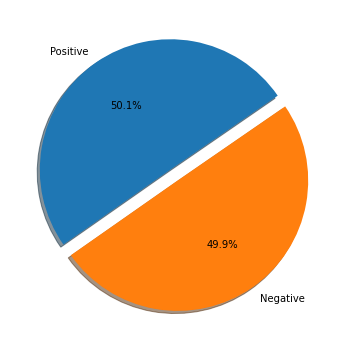

In [10]:
#Let us first analyze the distribution of the target variable

print('\033[1mTarget Variable Distribution'.center(55))
plt.pie(df[target].value_counts(), labels=['Positive','Negative'], counterclock=False, shadow=True, 
        explode=[0,0.1], autopct='%1.1f%%', radius=1, startangle=215)
plt.show()

**Inference:** The Target Variable seems to be perfectly balanced!

100%|██████████████████████████████████████████████████████████████████████████| 39723/39723 [00:18<00:00, 2115.41it/s]


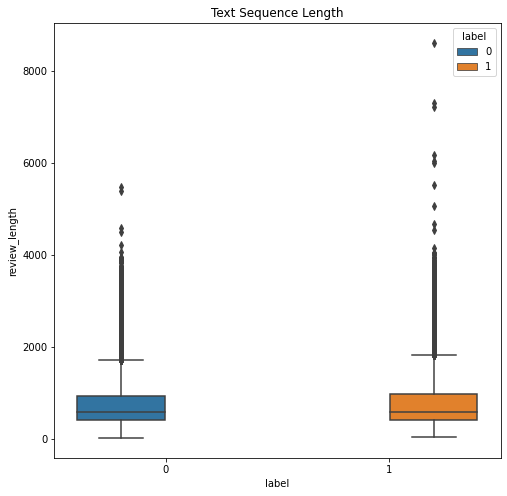

In [11]:
#Visualising the average text sequence length

df2 = df.copy()
df2['review_length'] = 0

for i in tqdm(range(df.shape[0])):
    df2['review_length'][i] = len(df2['text'][i])

plt.figure(figsize=[8,8])
sns.boxplot(x='label',y='review_length', data=df2, hue='label')
plt.title('Text Sequence Length')
plt.show()

**Inference:** The Positive reviews are slightly longer on an average, compared to those with negative reviews.

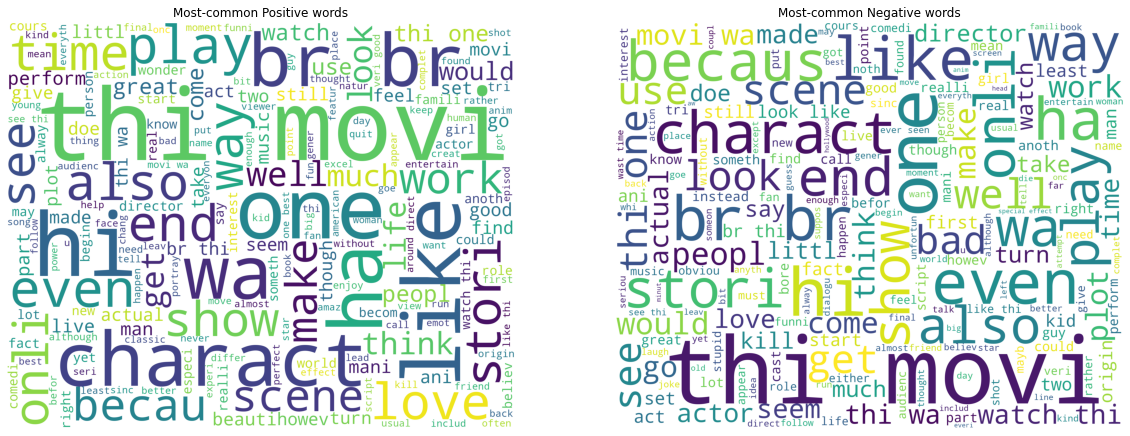

In [12]:
#Visualising the 

positivedata = df[df['label']== 1]
positivedata =positivedata['text']
negdata = df[df['label']== 0]
negdata= negdata['text']

def wordcloud_draw(data, color, s):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split() if(word!='movie' and word!='film')])
    wordcloud = WordCloud(stopwords=stopwords.words('english'),background_color=color,width=2500,height=2000).generate(cleaned_word)
    plt.imshow(wordcloud)
    plt.title(s)
    plt.axis('off')

plt.figure(figsize=[20,10])
plt.subplot(1,2,1)
wordcloud_draw(positivedata,'white','Most-common Positive words')

plt.subplot(1,2,2)
wordcloud_draw(negdata, 'white','Most-common Negative words')
plt.show()

---

## <center> 4. Predictive Modeling

In [13]:
#Splitting the data intro training & testing sets

X = df.drop([target],axis=1)
Y = df[target]
Train_X, Test_X, Train_Y, Test_Y = train_test_split(x, y, train_size=0.8, test_size=0.2, random_state=0)

print('Original set  ---> ',X.shape,Y.shape,'\nTraining set  ---> ',Train_X.shape,Train_Y.shape,'\nTesting set   ---> ', Test_X.shape,'', Test_Y.shape)

Original set  --->  (39723, 1) (39723,) 
Training set  --->  (31778, 119535) (31778,) 
Testing set   --->  (7945, 119535)  (7945,)


In [52]:
#Let us create first create a table to store the results of various models 

Evaluation_Results = pd.DataFrame(np.zeros((4,5)), columns=['Accuracy', 'Precision','Recall','F1-score','AUC-ROC score'])
Evaluation_Results.index=['Logistic Regression (LR)','Decision Tree Classifier (DT)','Random Forest Classifier (RF)','Naïve Bayes Classifier (NB)']
Evaluation_Results

,Accuracy,Precision,Recall,F1-score,AUC-ROC score
Logistic Regression (LR),0.0,0.0,0.0,0.0,0.0
Decision Tree Classifier (DT),0.0,0.0,0.0,0.0,0.0
Random Forest Classifier (RF),0.0,0.0,0.0,0.0,0.0
Naïve Bayes Classifier (NB),0.0,0.0,0.0,0.0,0.0


In [53]:
#Let us define functions to summarise the Prediction's scores .

#Classification Summary Function
def Classification_Summary(pred,pred_prob,i):
    Evaluation_Results.iloc[i]['Accuracy']=round(accuracy_score(Test_Y, pred),3)*100   
    Evaluation_Results.iloc[i]['Precision']=round(precision_score(Test_Y, pred),3)*100 #, average='weighted'
    Evaluation_Results.iloc[i]['Recall']=round(recall_score(Test_Y, pred),3)*100 #, average='weighted'
    Evaluation_Results.iloc[i]['F1-score']=round(f1_score(Test_Y, pred),3)*100 #, average='weighted'
    Evaluation_Results.iloc[i]['AUC-ROC score']=round(roc_auc_score(Test_Y, pred),3)*100 #, multi_class='ovr'
    print('{}{}\033[1m Evaluating {} \033[0m{}{}\n'.format('<'*3,'-'*35,Evaluation_Results.index[i], '-'*35,'>'*3))
    print('Accuracy = {}%'.format(round(accuracy_score(Test_Y, pred),3)*100))
    print('F1 Score = {}%'.format(round(f1_score(Test_Y, pred),3)*100)) #, average='weighted'
    print('\n \033[1mConfusiton Matrix:\033[0m\n',confusion_matrix(Test_Y, pred))
    print('\n\033[1mClassification Report:\033[0m\n',classification_report(Test_Y, pred))
    
    auc_roc(Test_Y, pred_prob, curves=['each_class'])
    plt.show()

#Visualising Function
def AUC_ROC_plot(Test_Y, pred):    
    ref = [0 for _ in range(len(Test_Y))]
    ref_auc = roc_auc_score(Test_Y, ref)
    lr_auc = roc_auc_score(Test_Y, pred)

    ns_fpr, ns_tpr, _ = roc_curve(Test_Y, ref)
    lr_fpr, lr_tpr, _ = roc_curve(Test_Y, pred)

    plt.plot(ns_fpr, ns_tpr, linestyle='--')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='AUC = {}'.format(round(roc_auc_score(Test_Y, pred)*100,2))) 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

---

## 1. Logistic Regression:

<<<----------------------------------- Evaluating Logistic Regression (LR) ----------------------------------->>>

Accuracy = 89.1%
F1 Score = 89.0%

 Confusiton Matrix:
 [[3584  500]
 [ 367 3494]]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.88      0.89      4084
           1       0.87      0.90      0.89      3861

    accuracy                           0.89      7945
   macro avg       0.89      0.89      0.89      7945
weighted avg       0.89      0.89      0.89      7945



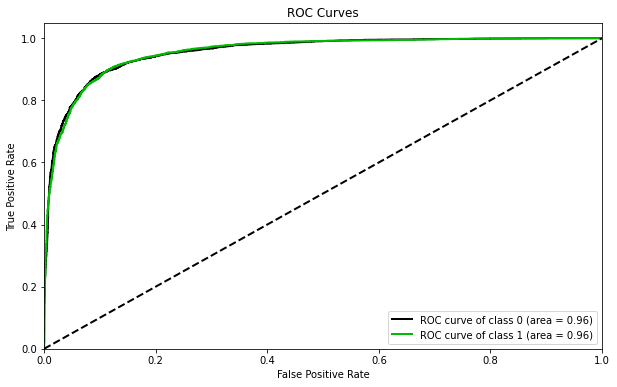

In [54]:
# Building Logistic Regression Classifier

LR_model = LogisticRegression()
LR = LR_model.fit(Train_X, Train_Y)
pred = LR.predict(Test_X)
pred_prob = LR.predict_proba(Test_X)
Classification_Summary(pred,pred_prob,0)

---

## 2. Decisoin Tree Classfier:

<<<----------------------------------- Evaluating Decision Tree Classifier (DT) ----------------------------------->>>

Accuracy = 70.7%
F1 Score = 69.89999999999999%

 Confusiton Matrix:
 [[2916 1168]
 [1157 2704]]

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.71      0.71      4084
           1       0.70      0.70      0.70      3861

    accuracy                           0.71      7945
   macro avg       0.71      0.71      0.71      7945
weighted avg       0.71      0.71      0.71      7945



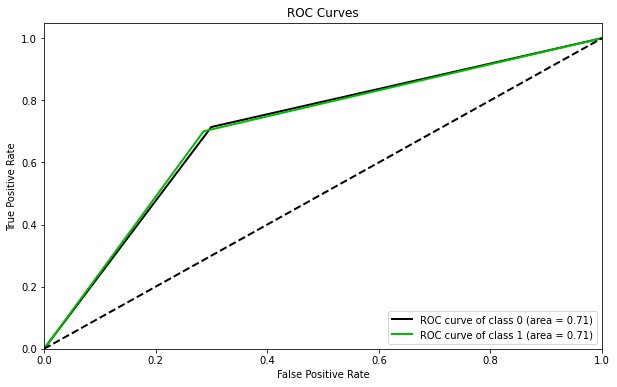

In [55]:
# Building Decision Tree Classifier

DT_model = DecisionTreeClassifier()
DT = DT_model.fit(Train_X, Train_Y)
pred = DT.predict(Test_X)
pred_prob = DT.predict_proba(Test_X)
Classification_Summary(pred,pred_prob,1)

---

## 3. Random Forest Classfier:

<<<----------------------------------- Evaluating Random Forest Classifier (RF) ----------------------------------->>>

Accuracy = 84.7%
F1 Score = 84.39999999999999%

 Confusiton Matrix:
 [[3436  648]
 [ 567 3294]]

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.84      0.85      4084
           1       0.84      0.85      0.84      3861

    accuracy                           0.85      7945
   macro avg       0.85      0.85      0.85      7945
weighted avg       0.85      0.85      0.85      7945



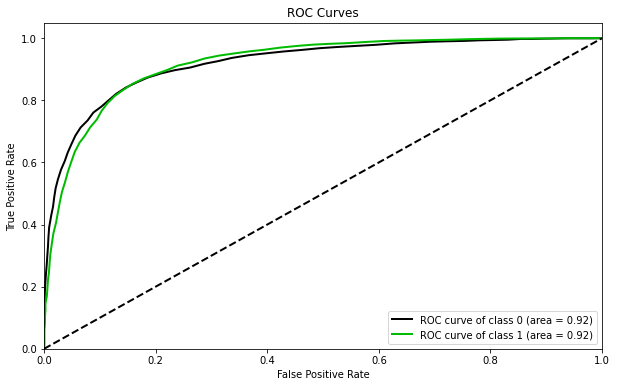

In [56]:
# Building Random Forest Classifier

RF_model = RandomForestClassifier()
RF = RF_model.fit(Train_X, Train_Y)
pred = RF.predict(Test_X)
pred_prob = RF.predict_proba(Test_X)
Classification_Summary(pred,pred_prob,2)

---

## 4. Naive Bayes Classfier:

<<<----------------------------------- Evaluating Naïve Bayes Classifier (NB) ----------------------------------->>>

Accuracy = 84.5%
F1 Score = 83.6%

 Confusiton Matrix:
 [[3578  506]
 [ 723 3138]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.88      0.85      4084
           1       0.86      0.81      0.84      3861

    accuracy                           0.85      7945
   macro avg       0.85      0.84      0.84      7945
weighted avg       0.85      0.85      0.85      7945



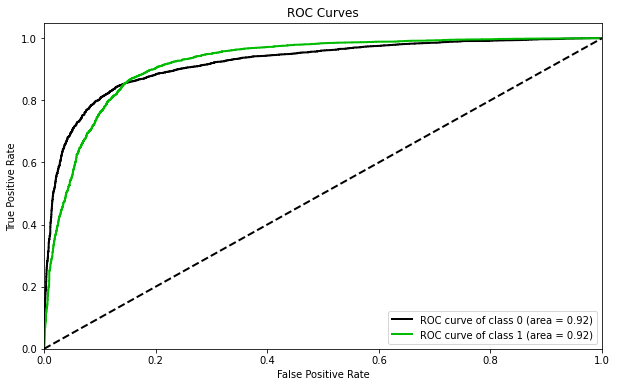

In [57]:
# Building Naive Bayes Classifier

NB_model = BernoulliNB()
NB = NB_model.fit(Train_X, Train_Y)
pred = NB.predict(Test_X)
pred_prob = NB.predict_proba(Test_X)
Classification_Summary(pred,pred_prob,3)

---

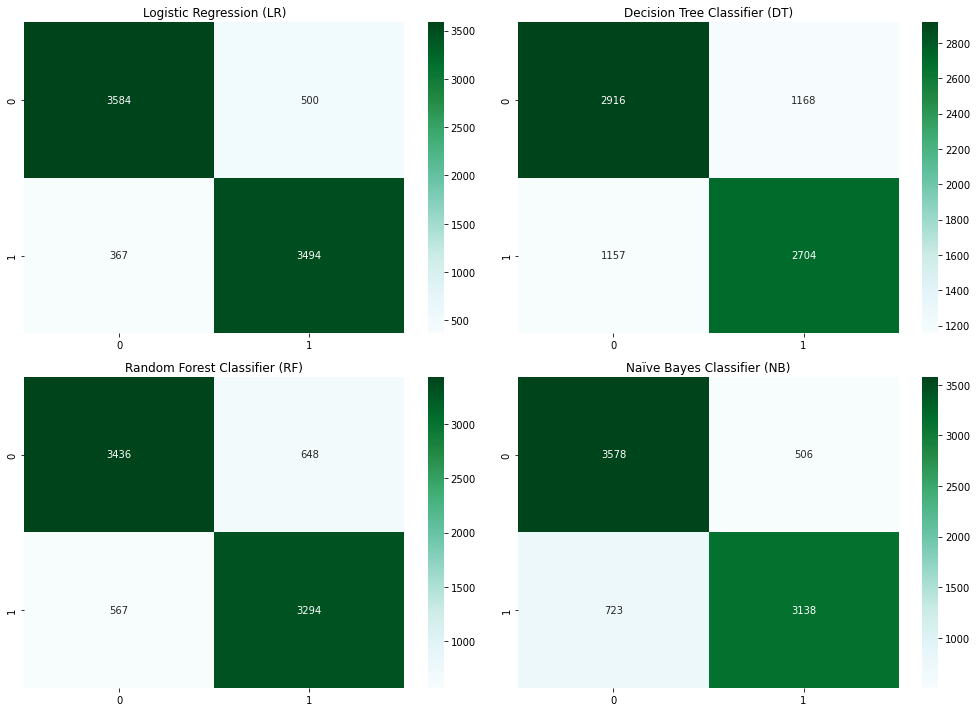

In [72]:
#Plotting Confusion-Matrix of all the predictive Models

labels=['Positive','Negative']
def plot_cm(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.columns=labels
    cm.index=labels
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    #fig, ax = plt.subplots()
    sns.heatmap(cm, annot=annot, fmt='')# cmap= "GnBu"
    
def conf_mat_plot(all_models):
    plt.figure(figsize=[14,5*math.ceil(len([all_models])*len(labels))])
    
    for i in range(len(all_models)):
        if len(labels)<=4:
            plt.subplot(2,2,i+1)
        else:
            plt.subplot(math.ceil(len(all_models)/2),2,i+1)
        pred = all_models[i].predict(Test_X)
        #plot_cm(Test_Y, pred)
        sns.heatmap(confusion_matrix(Test_Y, pred), annot=True, cmap='BuGn', fmt='.0f') #vmin=0,vmax=5
        plt.title(Evaluation_Results.index[i])
    plt.tight_layout()
    plt.show()

conf_mat_plot([LR,DT,RF,NB])

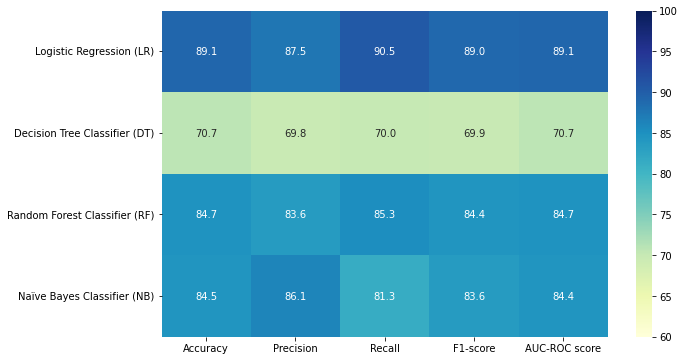

In [68]:
#Comparing all the models Scores

#plt.figure(figsize=[12,5])
sns.heatmap(Evaluation_Results, annot=True, vmin=60, vmax=100.0, cmap='YlGnBu', fmt='.1f')
plt.show()

**Insights:** For the current problem statement, it is more important to focus on the F1-score. Except Decision Tree Classifier, most of the algorithms perform well. The best performing algorithm is Logistic Regression...

---

## <center> 5. Project Outcomes & Conclusions

### Here are some of the key outcomes of the project:
- The Dataset was large enough totally around 40000 samples & preprocessing was done to clean the samples. 
- The positive & negative reviews were equally distributed.
- Visualising the distribution of data & their relationships, helped us to get some insights on the sparse matrix distribution.
- Testing multiple algorithms with default hyperparamters gave us some understanding for various models performance on this specific dataset.
- Surprisingly Logisitic Regression outperformed most of the other alogrithms. It is more generalisable & computationally less expensive.

In [ ]:
<<<----------------------------------------------------THE END------------------------------------------------------------->>>